In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
import random

# Map dimensions
MAP_WIDTH = 12
MAP_HEIGHT = 12  
GRID_SIZE = 1

# Convert feet to grid cells
GRID_WIDTH = int(MAP_WIDTH / GRID_SIZE)
GRID_HEIGHT = int(MAP_HEIGHT / GRID_SIZE)

offset = 1.458
lm_width = 0.255

# Define landmarks
landmarks = [
    (1 + offset - lm_width, 0, 1 + offset + lm_width, 1),  # Bottom-left, 2x1 rectangle
    (0, 1 + offset - lm_width, 1, 1 + offset + lm_width),  # Bottom-left, 2x1 rectangle
    (1 + offset - lm_width, GRID_HEIGHT - 1, 1 + offset + lm_width, GRID_HEIGHT),  # Top-left, 2x1 rectangle
    (0, GRID_HEIGHT - 1 - offset - lm_width, 1, GRID_HEIGHT - 1 - offset + lm_width),  # Top-left, 2x1 rectangle
    (GRID_WIDTH - 1 - offset - lm_width, 0, GRID_WIDTH - 1 - offset + lm_width, 1),  # Bottom-right, 2x1 rectangle
    (GRID_WIDTH - 1, 1 + offset - lm_width, GRID_WIDTH, 1 + offset + lm_width),  # Bottom-right, 2x1 rectangle
    (GRID_WIDTH - 1 - offset - lm_width, GRID_HEIGHT - 1, GRID_WIDTH - 1 - offset + lm_width, GRID_HEIGHT),  # Top-right, 2x1 rectangle
    (GRID_WIDTH - 1, GRID_HEIGHT - 1 - offset - lm_width, GRID_WIDTH, GRID_HEIGHT - 1 - offset + lm_width),  # Top-right, 2x1 rectangle
]

# Obstacle: larger square in the middle
obstacle = [
    (GRID_WIDTH // 2 - 0.834, GRID_HEIGHT - 1 - (4 + 0.666 + 0.833), GRID_WIDTH // 2 + 0.834, GRID_HEIGHT -1 - 4)
]

start = (GRID_WIDTH - 1 - 1, 1 + 2)
goal = (1 + 1, GRID_HEIGHT - 1 - 2)

shift_x, shift_y = start  # Calculate shift based on the start position

# Shift start, goal, obstacles, and landmarks
start = (0, 0)
goal = (goal[0] - shift_x, goal[1] - shift_y)

landmarks = [(x1 - shift_x, y1 - shift_y, x2 - shift_x, y2 - shift_y) for x1, y1, x2, y2 in landmarks]
obstacle = [(x1 - shift_x, y1 - shift_y, x2 - shift_x, y2 - shift_y) for x1, y1, x2, y2 in obstacle]

# Safety threshold in grid cells
SAFETY_THRESHOLD = 2


# Check if a node is safe
def is_safe(node, obstacle_cells):
    x, y = node
    for x_min, y_min, x_max, y_max in obstacle_cells:
        if x_min < x < x_max and y_min < y < y_max:
            return False
    return True


# A* Algorithm
def a_star(start, goal, edges):
    open_set = {start}
    came_from = {}
    g_score = {node: float('inf') for node in edges}
    f_score = {node: float('inf') for node in edges}
    
    g_score[start] = 0
    f_score[start] = heuristic(start, goal)
    
    while open_set:
        current = min(open_set, key=lambda node: f_score[node])
        if current == goal:
            return reconstruct_path(came_from, current)
        
        open_set.remove(current)
        for neighbor in edges[current]:
            tentative_g_score = g_score[current] + heuristic(current, neighbor)
            if tentative_g_score < g_score[neighbor]:
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g_score
                f_score[neighbor] = g_score[neighbor] + heuristic(neighbor, goal)
                if neighbor not in open_set:
                    open_set.add(neighbor)
    
    return []  # Return empty if no path


def heuristic(node1, node2):
    return np.linalg.norm(np.array(node1) - np.array(node2))


def reconstruct_path(came_from, current):
    path = [current]
    while current in came_from:
        current = came_from[current]
        path.append(current)
    path.reverse()
    return path


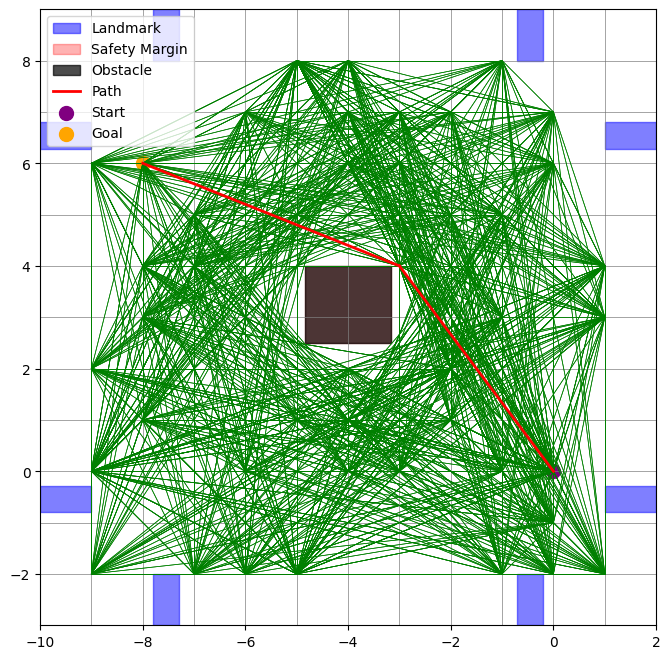

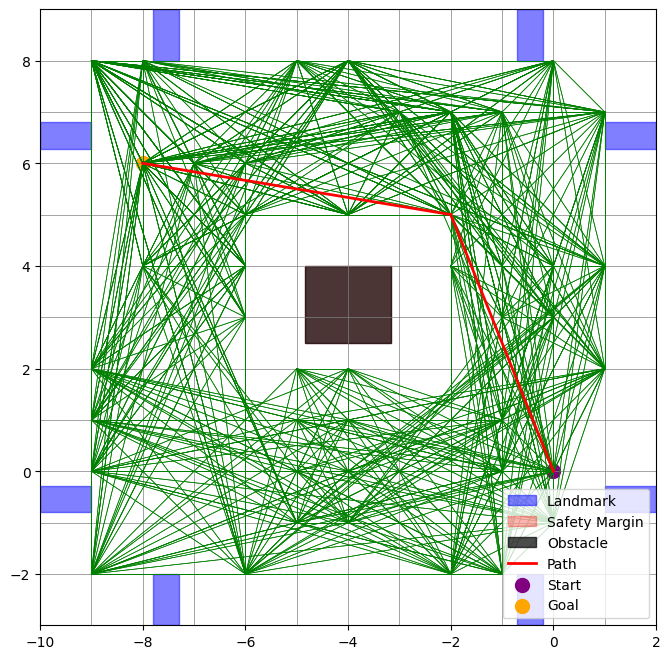

In [2]:
# fix seed
random.seed(12)

def create_visibility_graph(num_nodes, obstacle_cells, safety_margin=0):
    # Function to check if a line intersects any obstacle (with safety margin)
    def line_intersects_obstacle(line_start, line_end, obstacle_cells):
        x1, y1 = line_start
        x2, y2 = line_end
        for x_min, y_min, x_max, y_max in obstacle_cells:
            # Expand obstacle by the safety margin
            x_min_safe, y_min_safe = x_min - safety_margin, y_min - safety_margin
            x_max_safe, y_max_safe = x_max + safety_margin, y_max + safety_margin
            
            # Check for intersections with the edges of the expanded obstacle
            corners = [(x_min_safe, y_min_safe), (x_min_safe, y_max_safe), (x_max_safe, y_min_safe), (x_max_safe, y_max_safe)]
            edges = [(corners[i], corners[(i + 1) % 4]) for i in range(4)]
            for edge_start, edge_end in edges:
                if line_segments_intersect((x1, y1), (x2, y2), edge_start, edge_end):
                    return True
        return False

    def line_segments_intersect(p1, p2, q1, q2):
        def ccw(a, b, c):
            return (c[1] - a[1]) * (b[0] - a[0]) > (b[1] - a[1]) * (c[0] - a[0])
        return ccw(p1, q1, q2) != ccw(p2, q1, q2) and ccw(p1, p2, q1) != ccw(p1, p2, q2)

    near_obstacle_count = num_nodes // 2
    other_count = num_nodes - near_obstacle_count

    def is_near_obstacle(node, obstacle_cells, threshold=3):
        x, y = node
        for x_min, y_min, x_max, y_max in obstacle_cells:
            if (x_min - threshold <= x <= x_max + threshold and
                y_min - threshold <= y <= y_max + threshold):
                return True
        return False

    near_obstacle_nodes = []
    while len(near_obstacle_nodes) < near_obstacle_count:
        x = random.randint(-shift_x + 1, GRID_WIDTH - 1 - shift_x)
        y = random.randint(-shift_y + 1, GRID_HEIGHT - 1 - shift_y)
        if is_near_obstacle((x, y), obstacle_cells) and is_safe((x, y), obstacle_cells):
            near_obstacle_nodes.append((x, y))

    # Sample elsewhere
    other_nodes = []
    while len(other_nodes) < other_count:
        x = random.randint(-shift_x + 1, GRID_WIDTH - 1 - shift_x)
        y = random.randint(-shift_y + 1, GRID_HEIGHT - 1 - shift_y)
        if not is_near_obstacle((x, y), obstacle_cells) and is_safe((x, y), obstacle_cells):
            other_nodes.append((x, y))

    # Combine nodes
    nodes = near_obstacle_nodes + other_nodes
    nodes.append(start)
    nodes.append(goal)

    # Create edges based on visibility with safety margin
    edges = {node: [] for node in nodes}
    for i, node1 in enumerate(nodes):
        for j, node2 in enumerate(nodes):
            if i != j and not line_intersects_obstacle(node1, node2, obstacle_cells):
                edges[node1].append(node2)

    return nodes, edges


# Visualization for Safety Drive
def visualize_visibility_graph(path, nodes, edges, obstacle_cells, safety_margin=0):
    fig, ax = plt.subplots(figsize=(8, 8))

    # Draw grid
    for x in range(-shift_x, GRID_WIDTH - shift_x):
        for y in range(-shift_y, GRID_HEIGHT - shift_y):
            ax.plot([x, x + 1], [y, y], color='gray', linewidth=0.5)
            ax.plot([x, x], [y, y + 1], color='gray', linewidth=0.5)


    # Draw landmarks and obstacles
    for lm in landmarks:
        x_min, y_min, x_max, y_max = lm
        ax.add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, color='blue', alpha=0.5, label="Landmark" if lm == landmarks[0] else ""))
    for x_min, y_min, x_max, y_max in obstacle_cells:
        # Draw expanded obstacle with safety margin
        x_min_safe, y_min_safe = x_min - safety_margin, y_min - safety_margin
        x_max_safe, y_max_safe = x_max + safety_margin, y_max + safety_margin
        ax.add_patch(plt.Rectangle((x_min_safe, y_min_safe), x_max_safe - x_min_safe, y_max_safe - y_min_safe, color='red', alpha=0.3, label="Safety Margin" if x_min == obstacle_cells[0][0] else ""))
        ax.add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, color='black', alpha=0.7, label="Obstacle" if x_min == obstacle_cells[0][0] else ""))

    # Draw edges
    for node, neighbors in edges.items():
        for neighbor in neighbors:
            ax.plot([node[0], neighbor[0]], [node[1], neighbor[1]], color='green', linewidth=0.5)

    # Draw path
    if path:
        for i in range(len(path) - 1):
            ax.plot([path[i][0], path[i + 1][0]], [path[i][1], path[i + 1][1]], color='red', linewidth=2, label="Path" if i == 0 else "")

    # Mark start and goal positions
    ax.scatter(start[0], start[1], color='purple', s=100, label="Start")
    ax.scatter(goal[0], goal[1], color='orange', s=100, label="Goal")

    ax.set_xlim(-shift_x, GRID_WIDTH - shift_x)
    ax.set_ylim(-shift_y, GRID_HEIGHT - shift_y)
    ax.set_aspect('equal')
    plt.legend()
    plt.show()


# def main():
num_nodes = 50
safety_margin = 0 # zero for time
time_nodes, time_edges = create_visibility_graph(num_nodes, obstacle, safety_margin=0)
safety_nodes, safety_edges = create_visibility_graph(num_nodes, obstacle, safety_margin=1)

time_path = a_star(start, goal, time_edges)
safety_path = a_star(start, goal, safety_edges)
visualize_visibility_graph(time_path, time_nodes, time_edges, obstacle, safety_margin)
visualize_visibility_graph(safety_path, safety_nodes, safety_edges, obstacle, safety_margin)


# if __name__ == "__main__":
#     main()


In [ ]:
# Minimum Time/Distance Path Waypoints
meters = np.array(time_path) * 0.3048

xys = meters[:, [1, 0]]  # Swap x and y
xys[:, 1] *= -1      # Multiply y (new column) by -1

thetas = [0]  # Initialize the first theta as 0

for i in range(1, len(xys)):
    dx = xys[i, 0] - xys[i - 1, 0]
    dy = xys[i, 1] - xys[i - 1, 1]
    theta = np.arctan2(dy, dx)
    thetas.append(theta)

# Combine waypoints with thetas
result = np.hstack((xys, np.array(thetas).reshape(-1, 1)))

print(result)

[[ 0.         -0.          0.        ]
 [ 1.2192      0.9144      0.64350111]
 [ 1.8288      2.4384      1.19028995]]


In [ ]:
# Maximum Safety Path Waypoints
meters = np.array(safety_path) * 0.3048

xys = meters[:, [1, 0]]  # Swap x and y
xys[:, 1] *= -1      # Multiply y (new column) by -1

thetas = [0]  # Initialize the first theta as 0

for i in range(1, len(xys)):
    dx = xys[i, 0] - xys[i - 1, 0]
    dy = xys[i, 1] - xys[i - 1, 1]
    theta = np.arctan2(dy, dx)
    thetas.append(theta)

# Combine waypoints with thetas
result = np.hstack((xys, np.array(thetas).reshape(-1, 1)))

print(result)

[[ 0.         -0.          0.        ]
 [ 1.524       0.6096      0.38050638]
 [ 1.8288      2.4384      1.40564765]]
